# **Data science workshop project**
**Team:** Elad, Tsach, Oz, Eva

**Problem:** The predictors of in-hospital mortality for admitted patients remain poorly characterized.

**Goal of the project**: We aimed to develop and validate a prediction model for all-cause in-hospital mortality among admitted patients.


## Introduction: understand and clean the dataset

In [31]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [32]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#Machine learning library
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics

from Model.ModelModule import DSWorkshopModel  # separate python file which hold data and run models

In [33]:
complete_data = pd.read_csv('dataset.csv') #load the dataset

In [34]:
complete_data.head() #beginning of the dataset

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.73,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.42,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.95,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.64,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0


In [35]:
complete_data.shape   #dataset sizes: 85 columns and 91713 rows/patients in the original dataset

(91713, 85)

In [36]:
#column / features and data types
complete_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

## Labels for prediction

In [37]:
complete_data["hospital_death"].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

In [38]:
class_prediction = "hospital_death" #label

([<matplotlib.patches.Wedge at 0x175a36f95b0>,
 [Text(-1.0598172020063896, 0.294597179774939, '0'),
  Text(1.0598172295885635, -0.2945970805476902, '1')],
 [Text(-0.5780821101853033, 0.16068937078633036, '91.4%'),
  Text(0.5780821252301255, -0.16068931666237643, '8.6%')])

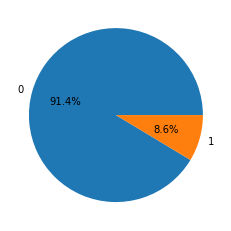

In [39]:
unique_labels = np.unique(complete_data[class_prediction])
plt.pie(np.array([len(complete_data[complete_data[class_prediction]==label]) for label in unique_labels ]), labels = list(unique_labels), autopct='%1.1f%%')

The distribution of classes is really different so it will be a challenge for the model to predict class 1 which is "death"

The distribution of the two classes is unbalanced at all : it will be challenging because most of the patients in the dataset haven t hospital mortality.

## Features

In [40]:
numerical_features = ["age", "bmi","height", "weight", 
                      "pre_icu_los_days", "gcs_eyes_apache","apache_2_diagnosis",
                      "gcs_motor_apache", "gcs_verbal_apache", "heart_rate_apache",
                     "map_apache", "resprate_apache", "temp_apache", "d1_diasbp_max",
                      "d1_diasbp_min","d1_diasbp_noninvasive_max", "d1_diasbp_noninvasive_min",
                      "d1_heartrate_max", "d1_heartrate_min", "d1_mbp_max", "d1_mbp_min", 
                      "d1_mbp_noninvasive_max", "d1_mbp_noninvasive_min", "d1_resprate_max", "d1_resprate_min",
                      "d1_spo2_max", "d1_spo2_min", "d1_sysbp_max", "d1_sysbp_min",
                      "d1_sysbp_noninvasive_max", "d1_sysbp_noninvasive_min", "d1_temp_max", "d1_temp_min",
                      "h1_diasbp_max", "h1_diasbp_min", "h1_diasbp_noninvasive_max", "h1_diasbp_noninvasive_min",
                      "h1_heartrate_max", "h1_heartrate_min", "h1_mbp_max", "h1_mbp_min",
                      "h1_mbp_noninvasive_max", "h1_mbp_noninvasive_min", "h1_resprate_max", "h1_resprate_min",
                      "h1_spo2_max", "h1_spo2_min", "h1_sysbp_max", "h1_sysbp_min",
                      "h1_sysbp_noninvasive_max", "h1_sysbp_noninvasive_min", "d1_glucose_max", "d1_glucose_min",
                      "d1_potassium_max", "d1_potassium_min", "apache_4a_hospital_death_prob", "apache_4a_icu_death_prob",
                      "apache_3j_diagnosis"]

categorial_features = ["hospital_id", "ethnicity", "gender", "icu_admit_source", "apache_3j_bodysystem", "apache_2_bodysystem", "icu_stay_type", "icu_type"]

binary_features = ["arf_apache", "gcs_unable_apache", "intubated_apache", 
                   "ventilated_apache", "elective_surgery", "apache_post_operative",
                   "aids", "cirrhosis", "diabetes_mellitus", "hepatic_failure", "immunosuppression",
                   "leukemia", "lymphoma", "solid_tumor_with_metastasis"]

## Influence of the age of the patient on the hospital death

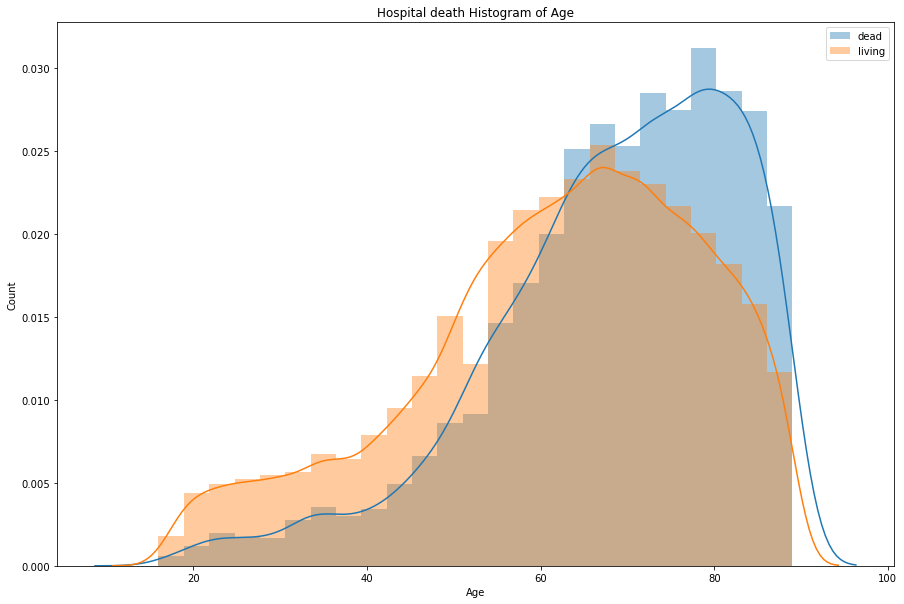

In [41]:
dead_patient = complete_data[complete_data["hospital_death"] == 1]
living_patient =  complete_data[complete_data["hospital_death"] == 0]

fig,ax=plt.subplots(figsize=(15,10))

#create two histograms
sns.distplot(dead_patient.age, bins = 25, kde = True, label = "dead",ax=ax)
sns.distplot(living_patient.age, bins = 25, kde = True, label = "living",ax=ax)

plt.title('Hospital death Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(loc="upper right")

## Understand binary features

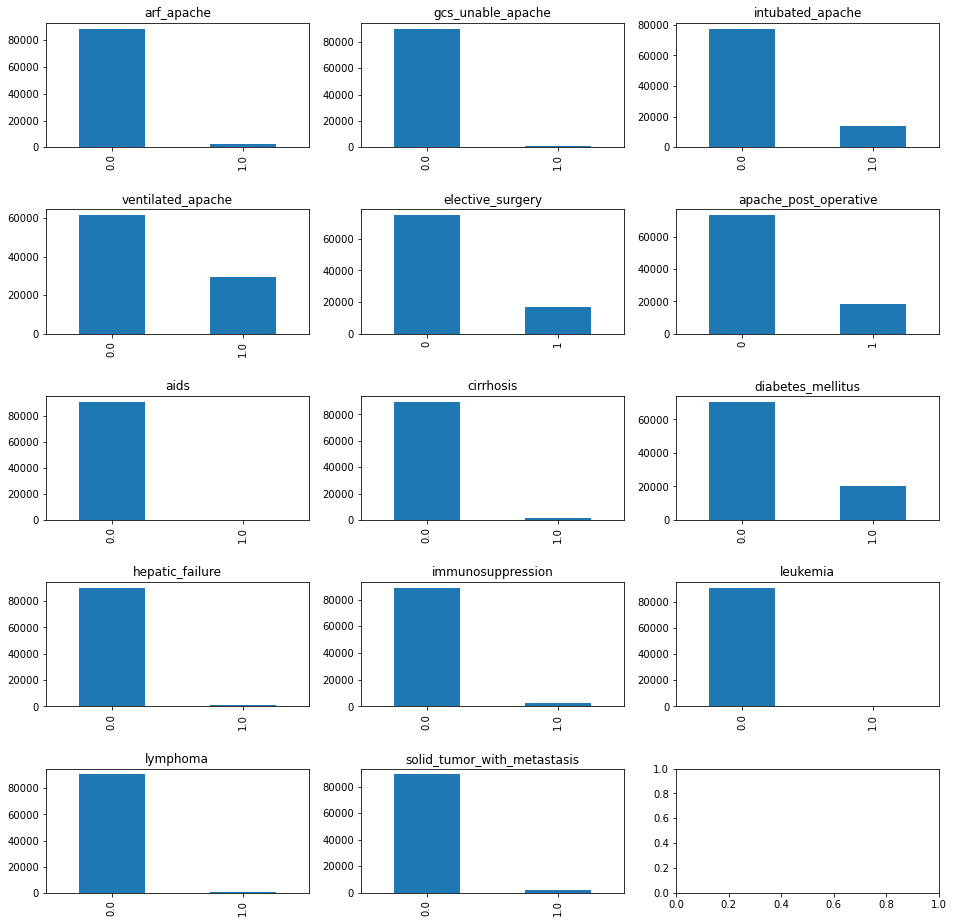

In [42]:
fig, axes = plt.subplots(5,3,figsize=(16,16))
fig.subplots_adjust(hspace=0.5)

#we will create a histogram for each categorical attribute
n=len(binary_features)
num_rows = 3
max_bars = 5

for i,variable in enumerate(binary_features):
    #calculate the current place on the grid
    r=int(i/num_rows)
    c=i%num_rows
    
    #create the "value counts" for the first <max_bars> categories:
    u=min(complete_data[variable].nunique(),max_bars)
    vc = complete_data[variable].value_counts()[:u]
    #vc.locator_params(axis ='x', nbins = 10) # for noamlization but not working
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c],title=variable)

Most of values are 0 so we will change the representation:
    fill missing values with 0 
    add column which tell when this feature is missing

## Check number of missing values

In [43]:
pd.set_option('display.max_rows', None)
def NaN_info(df):
    global null_view
    try:
        null_view = df[[col for col in df.columns if df[col].isna().sum() > 0]].isna().sum().sort_values(ascending = True)
        null_view = pd.DataFrame(null_view, columns=['Missing values count'])
    except:
        return null_view
    return null_view

NaN_info(complete_data)

,Missing values count
gender,25
icu_admit_source,112
d1_heartrate_min,145
d1_heartrate_max,145
d1_sysbp_max,159
d1_sysbp_min,159
d1_diasbp_min,165
d1_diasbp_max,165
d1_mbp_max,220
d1_mbp_min,220


Many missing values: we need to find methos to fill them

## Methods for dataset

In [44]:
def getBasicDataset(): #return dataset without empty column, shuffled and with onehot encoding
    complete_data = pd.read_csv('dataset.csv') #load the dataset
    complete_data.drop(complete_data.columns[[0,1,83]], axis=1, inplace=True) #delete feature 83
    complete_data = complete_data.sample(frac=1) #shuffle
    complete_data = pd.get_dummies(complete_data,columns=categorial_features) #one hot encoding
    return complete_data

In [45]:
# Filling missing NUMERICAL values with mean
def fill_missing_num_values_with_mean(complete_data):
    for feature in numerical_features:
        if feature in complete_data.columns:
            mean_value = complete_data[feature].mean()
            complete_data[feature].fillna(value=mean_value, inplace=True)
    return complete_data

In [46]:
def fill_missing_values_binary(df): 
    #add column for binary missing values
    binary_features_with_missing_values = df[binary_features].columns[df[binary_features].isnull().any()]
    for f in binary_features_with_missing_values:
        name = "missing " + f
        df[name] = (df[f].isnull()).astype(int) # add feature which tell when value is missing
    # change missing values to 0 in the original feature
    for f in binary_features:
        df[f] = df[f].fillna(0)
    return df

In [47]:
feature_to_Nan=['h1_diasbp_noninvasive_max', 'temp_apache','h1_diasbp_noninvasive_min','age', 'd1_potassium_max', 'weight', 'h1_diasbp_min','h1_sysbp_min', 'd1_potassium_min','apache_2_diagnosis']

def addRows(df):
    fakeRowsIndex = []
    to_remove =[]
    deadRows = df[df['hospital_death'] == 1]
    for index, row in deadRows.iterrows():
        if row.isna().sum().sum() > 10:
            to_remove.append(index)
    deadRows = deadRows.drop(to_remove)
    pd.concat([deadRows]*4, ignore_index=True) #duplicate each row 4 times
    for f in feature_to_Nan:
        deadRows[f] = df[f].sample(frac=0.8)
    fakeRowsIndex = deadRows.index
    final_Df = pd.concat([df, deadRows], axis=0)
    return final_Df, fakeRowsIndex, deadRows


In [48]:
def runModel(df):
    model = DSWorkshopModel(df)
    train_data = df.drop('hospital_death', axis=1)
    true_values = df.hospital_death
    x_train, x_test, y_train, y_test = train_test_split(train_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)
    model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
    model.train()
    return model

In [49]:
def createBMI_cat(complete_data):
    bmi_cat = ['Severe Thinness', 'Moderate Thinness','Mild Thinness','Normal', 
           'Overweight','Obese l1',"Obese l2"," Obese l3","missing bmi 2"]
    category_bmi = pd.cut(complete_data['bmi'], bins=[0,16,17,18.5,25,30,35,40,80,100], labels=bmi_cat)
    complete_data.insert(9,'bmi group',category_bmi)
    complete_data.drop('bmi', inplace=True, axis=1)
    complete_data = pd.get_dummies(complete_data,columns=['bmi group'])
    complete_data.drop('bmi group_missing bmi 2', inplace=True, axis=1) 
    return complete_data

In [50]:
def generate_gcs_score(row): #sum each component
    return row['gcs_motor_apache']+row['gcs_verbal_apache']+row['gcs_eyes_apache']

def dealWithGCS(df3):
    gcs_params = ['gcs_motor_apache', 'gcs_verbal_apache','gcs_eyes_apache']
    gcs_data = df3[gcs_params]
    df3['gcs_score']=df3.apply(generate_gcs_score,axis=1)
    gcs_cat = ['Severe', 'Moderate','Mild']
    category_gcs = pd.cut(df3['gcs_score'], bins=[3,8,12,15], 
                          labels=gcs_cat)
    df3.insert(3,'gcs group',category_gcs)
    df3 = pd.get_dummies(df3,columns=['gcs group'])
    df3 = df3.drop('gcs_score', axis=1)
    return df3

In [51]:
from sklearn.metrics import confusion_matrix
def conf_matrix(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

## 1. Run Model on original dataset 
(We filled all missing values which are numerical with mean and add column which tell when data is missing), we also apply one hot encoding for original categorical features. 

In [52]:
df1 = getBasicDataset()
df1 = fill_missing_num_values_with_mean(df1)
df1 = fill_missing_values_binary(df1)

In [53]:
model = DSWorkshopModel(df1)

In [54]:
# Preparing the data
train_data = df1.drop('hospital_death', axis=1)
true_values = df1.hospital_death
x_train, x_test, y_train, y_test = train_test_split(train_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)

In [55]:
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

In [56]:
model.train()

In [57]:
models_predictions, pred_results = model.test()

In [58]:
print(pred_results)

          Method  Precision Score  Recall Score  F1 Score  \
0   RandomForest         0.722117      0.241314  0.361742   
1     ExtraTrees         0.767857      0.190145  0.304810   
2  XGBClassifier         0.669231      0.329754  0.441811   

   Unbalanced Accuracy Score  Balanced Accuracy Score  \
0                   0.926511                 0.616272   
1                   0.925149                 0.592358   
2                   0.928092                 0.657180   

   Positive Accuracy Score  Negative Accuracy Score Time Needed for Training  
0                  0.24131                  0.99123                   34.09s  
1                  0.19015                  0.99457                   35.43s  
2                  0.32975                  0.98461                   63.76s  


For original dataset, we have results of around:
- 70 % precision score
- 20 % recall
- 99 % accuracy for negative
- 33 % accuracy for positive

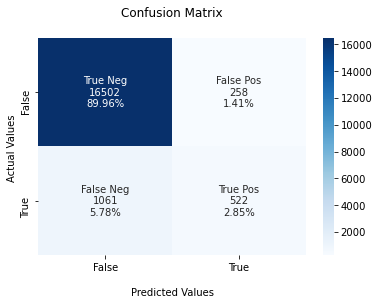

In [59]:
cf_matrix = confusion_matrix(y_test.to_numpy(), models_predictions[-1])
conf_matrix(cf_matrix)

A true positive is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class.

A false positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.

=> We can see that we need to reduce the amount of false negative: so we need to maybe improve feature which influence a lot on the result.

Let s try to check SHAP result to see feature importance

### Evaluation Plots

maKE IKE AMIT NOTEBOOK
ROC CURVE!!!!!

In [ ]:
y_true = y_test
predicted_probs = logreg.predict_proba(x_test)
y_score = predicted_probs[:,1]

In [ ]:
# need to do same as amit notebook

### SHAP on basic model

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


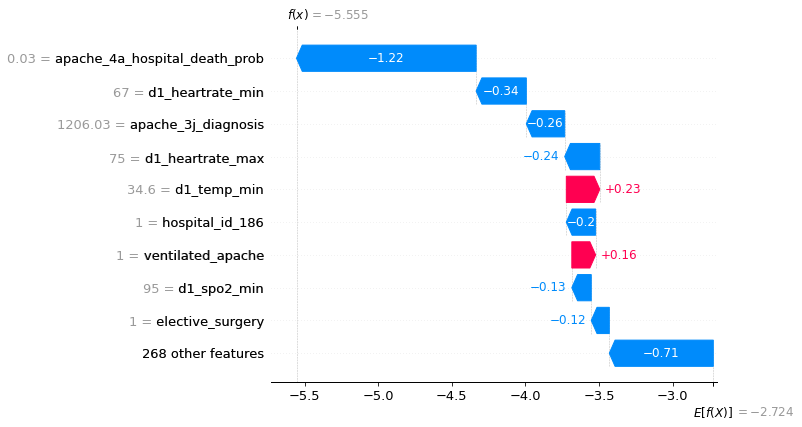

In [60]:
import shap
shap.initjs()
models = model.get_models()
    
explainer = shap.Explainer(models[2])
shap_values = explainer(train_data)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])


In [61]:
#explaining prediction of true : death
shap_values_100 = explainer(x_test[:100])

shap.plots.waterfall(shap_values_100[2], max_display=14)

NameError: name 'shap_values_100' is not defined

In [ ]:
#Summary of Shap values for all features across our 100 first predictions
shap.plots.beeswarm(shap_values_100, max_display=14)

need to make it on different models and take decision on what to do
maybe try to understand why the odel give bad prediction?

## 2. Trying to add artificial data

In [ ]:
df5 = getBasicDataset()

df5, fakeRowsIndex, fakeRows = addRows(df5) #create new rows for label 1

df5 = fill_missing_num_values_with_mean(df5)
df5 = fill_missing_values_binary(df5)
df5 = createBMI_cat(df5)
df5 = dealWithGCS(df5)
unique_labels = np.unique(df5[class_prediction])
plt.pie(np.array([len(df5[df5[class_prediction]==label]) for label in unique_labels ]), labels = list(unique_labels), autopct='%1.1f%%')


model = DSWorkshopModel(df5)
train_data = df5.drop('hospital_death', axis=1)
true_values = df5.hospital_death

x_train, x_test, y_train, y_test = train_test_split(train_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)

# we don t want to predict for fake rows
# for row in x_test:
#     if row in fakeRows :
#         x_test.remove(row)
#         i = row.index
#         y_test[i].remove()


model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

model.train()


model = runModel(df5)
models_predictions, pred_results = model.test()
print(pred_results)

## 3. First try to improve the model : improve dataset with improving BMI data

In [ ]:
df2 = getBasicDataset()
bmi_set = df2[['bmi','weight','height']]
bmi_set[bmi_set.isnull().any(axis=1)].head(10)

Bmi is a feature which depends on weigh and heigh which already appear in the dataset. BMI has many missing value but when it is missing, also weigh or heigh is missing so we cannot compute it to fill missing values.

In [ ]:
df2 = createBMI_cat(df2)
df2 = fill_missing_num_values_with_mean(df2)
df2 = fill_missing_values_binary(df2)

In [ ]:
model = DSWorkshopModel(df2)
train_data = df2.drop('hospital_death', axis=1)
true_values = df2.hospital_death
x_train, x_test, y_train, y_test = train_test_split(train_data, true_values, test_size=0.2, stratify=true_values, shuffle=True)
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
model.train()
models_predictions, pred_results = model.test()
print(pred_results)

After changing bmi, let s see if we have better results: 83.8% precision, before we had 80%.
Lets try now to improve more, by giving more meaning to our dataset

## 4.  Improve dataset with adding meaning to GCS data

This test gives a score that helps to know how much a person is in danger to die: we will try to add the result to the data because it s not given in the original data: we have only score for each component of the test: eyes, motor and verbal.
GCS - Glasgow Coma Scale : clinical scale used to reliably measure a person's level of consciousness after a brain injury. The score can be between 3 and 15 and can be separate in category:

3-8 severe
9-12 moderate
13-15 mild
=> Low score is correlated with higher risk of death.

In [ ]:
df3 = getBasicDataset()
df3 = createBMI_cat(df3)
df3 = dealWithGCS(df3)

In [ ]:
df3 = fill_missing_num_values_with_mean(df3)
df3 = fill_missing_values_binary(df3)
df3[['gcs group_Moderate','gcs group_Severe', 'gcs group_Mild', 'gcs_unable_apache']].head() #we will see new column: gcs_score and all binary column for moderate, severe,mild

In [ ]:
model = runModel(df3)
models_predictions, pred_results = model.test()
print(pred_results)

results of adding gsc data: improve result : so we keep it

## 5. Normalize data

In [ ]:
df4 = getBasicDataset()
df4 = fill_missing_num_values_with_mean(df4)
df4 = fill_missing_values_binary(df4)
model = DSWorkshopModel(df4)
x = df4.drop('hospital_death', axis=1)

scaler = preprocessing.StandardScaler().fit(x)
x_transformed = scaler.transform(x)

true_values = df4.hospital_death
x_train, x_test, y_train, y_test = train_test_split(x_transformed, true_values, test_size=0.2, stratify=true_values, shuffle=True)
model.set_split(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
model.train()

models_predictions, pred_results = model.test()
print(pred_results)

In [ ]:
# remove features
# remove rows with too much missing values
# change distribution of the labels  (50/50)
# add data with missing values from original rows for label 1
